# Initialize PySpark
We are importing findspark to use findspark.init() to make pyspark importable as a regular library.

In [1]:
import findspark
findspark.init()

**Graphframes Package**

GraphFrames is a package for Apache Spark which provides DataFrame-based Graphs. It provides high-level APIs in Scala, Java, and Python. It aims to provide both the functionality of GraphX and extended functionality taking advantage of Spark DataFrames.

The following lines are used to set up the PySpark Environment to include GraphFrames package.

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.0-spark3.0-s_2.12" pyspark-shell'


# Creation of Entry point
We will be using SparkSession to create the entry point of programming Spark with the Dataset and DataFrame API, providing means to interact with various spark’s functionality. 

The spark session builder will try to get a spark session if there is one already created or create a new one and assigns the newly created SparkSession as the global default. 

We are using SparkSession, instead of SparkContext because it unifies all the different contexts. 

In [3]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
            .appName("Expedia")\
            .getOrCreate()

**Graphframes**

We need to import it to be used for Graph Analytics 

In [4]:
from graphframes import GraphFrame

In [62]:
# Necessary packages to be imported
from IPython.display import display, Markdown,HTML
from pyspark.sql.functions import *

display(HTML("<style>.container { width:90% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Uploading and Creation of Dataset

With a SparkSession in place, application can create DataFrames from an existing csv, Expedia Dataset.

By setting inferSchema as true , Spark will automatically go through the csv file and infer the schema of each column, requiring extra resource making the execution being slower, but not need to set schema for each column after wards.

By setting the header as true, we are specifying the first row, has the column names and will not be considered as part of observations.

In [ ]:
exp_df = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .csv("Expedia_Dataset.csv") \
                 .cache() # optimization to make the processing faster

# Feature Description

|Column name|Description|Data type|
|-----|:-------|------|
|date_time|Timestamp|string|
|site_name|ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)|int| 
|posa_continent|ID of continent associated with site_name |int|
|user_location_country|ID of the country the customer is located|int|
|user_location_region|ID of the region the customer is located|int|
|user_location_city|ID of the city the customer is located|int|
|orig_destination_distance|Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated|double|
|user_id|ID of user|int|
|is_mobile| when a user connected from a mobile device, 0 otherwise|tinyint|
|is_package|1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise|int|
|channel|ID of a marketing channel|int|
|srch_ci|Checkin date|string|
|srch_co|Checkout date|string|
|srch_adults_cnt|The number of adults specified in the hotel room|int|
|srch_children_cnt|The number of (extra occupancy) children specified in the hotel room |int|
|srch_rm_cnt|The number of hotel rooms specified in the search |int|
|srch_destination_id|ID of the destination where the hotel search was performed |int|
|srch_destination_type_id|Type of destination|int|
|hotel_continent|Hotel continent|int|
|hotel_country|Hotel country|int|
|hotel_market|Hotel market|int|
|is_booking |1 if a booking, 0 if a click|tinyint|
|cnt|Numer of similar events in the context of the same user session|bigint|
|hotel_cluster|ID of a hotel cluster|int|

# Conversion

Function defined to save the above dataframe into parquet files for ease of accessibility.

In [ ]:
def save(df,f):
    df.write.mode("overwrite").format(f).save("Expedia/" + f + "/")

[save(exp_df,f) for f in ["parquet"]]

**Verify**

The below function defined loads the parquet files created and shows the first 5 observations.

In [ ]:
def load_and_show(f):
    print(f)
    spark.read.format(f).load("Expedia/" + f + "/").show(5,False)

[load_and_show(f) for f in ["parquet"]]

# Set the proper Schema
We are loading from the parquet files and setting proper datatypes to each columns. Currently, three columns are being modified.

1. date_time: timestamp (Earlier: String)
2. srch_ci: date (Earlier String)
3. srch_co: date (Earlier String)

We need to do these modifications to have date time analysis on the dataset.

Finally, we are saving the contents of the SparkDataFrame to a data source as a ***table*** with write mode as ***overwrite***, so that the existing data is expected to be overwritten by the contents of this SparkDataFrame.

In [6]:
exp = spark.read.parquet("../Spark_Assignment/Expedia/parquet/")
exp = exp.select(col("date_time").cast("timestamp"),
                 col("srch_ci").cast("date"),
                 col("srch_co").cast("date"),
                 col('site_name').cast("int"),
                 col('posa_continent').cast("int"),
                 col('user_location_country').cast("int"),
                 col('user_location_region').cast("int"),
                 col('user_location_city').cast("int"),
                 col('orig_destination_distance').cast("int"),
                 col('user_id').cast("int"),
                 col('is_mobile').cast("int"),
                 col('is_package').cast("int"),
                 col('channel').cast("int"),
                 col('srch_adults_cnt').cast("int"),
                 col('srch_children_cnt').cast("int"),
                 col('srch_rm_cnt').cast("int"),
                 col('srch_destination_id').cast("int"),
                 col('srch_destination_type_id').cast("int"),
                 col('is_booking').cast("int"),
                 col('cnt').cast("int"),
                 col('hotel_continent').cast("int"),
                 col('hotel_country').cast("int"),
                 col('hotel_market').cast("int"),
                 col('hotel_cluster').cast("int"))
spark.sql("drop table if exists exp")
exp.write.mode("overwrite").saveAsTable("exp") 

**Basic Schema and Size of the Dataset**

In [7]:
exp.printSchema()
display(Markdown("This DataFrame has **%d** rows." % exp.count()))

root
 |-- date_time: timestamp (nullable = true)
 |-- srch_ci: date (nullable = true)
 |-- srch_co: date (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: integer (

This DataFrame has **37670293** rows.

In [8]:
# Name of the columns and its corresponding datatype
exp.dtypes 

[('date_time', 'timestamp'),
 ('srch_ci', 'date'),
 ('srch_co', 'date'),
 ('site_name', 'int'),
 ('posa_continent', 'int'),
 ('user_location_country', 'int'),
 ('user_location_region', 'int'),
 ('user_location_city', 'int'),
 ('orig_destination_distance', 'int'),
 ('user_id', 'int'),
 ('is_mobile', 'int'),
 ('is_package', 'int'),
 ('channel', 'int'),
 ('srch_adults_cnt', 'int'),
 ('srch_children_cnt', 'int'),
 ('srch_rm_cnt', 'int'),
 ('srch_destination_id', 'int'),
 ('srch_destination_type_id', 'int'),
 ('is_booking', 'int'),
 ('cnt', 'int'),
 ('hotel_continent', 'int'),
 ('hotel_country', 'int'),
 ('hotel_market', 'int'),
 ('hotel_cluster', 'int')]

# Basic Statistics
We are using ***summary()*** to find the basic statistics of all the columns ( Except the timestamp and date datatypes), including mean, median, quantiles, min and max. Most of the attributes are categorical, so these statistics do not make much sense, except the ***min*** and ***max***. The only five continuous variables, being:

1. orig_destination_distance: int
2. srch_adults_cnt: int
3. srch_children_cnt: int
4. srch_rm_cnt: int
5. cnt: int

This analysis is followed by checking of ***null values*** within the columns, so that those can be imputed for dealt with accordingly.

In [9]:
exp.summary().toPandas()

,summary,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,count,37670293,37670293,37670293,37670293,37670293,24145292,37670293,37670293,37670293,...,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293
1,mean,9.795271329585889,2.6804730188851997,86.10880194109454,308.4060117610447,27753.044729330883,1969.590628640979,604451.7531778422,0.1349265056154461,0.24890422275186444,...,0.3321221579030458,1.1126628083301608,14441.090543760836,2.5822799148389954,0.07965674702875288,1.4833839227106622,3.1563047837190967,81.29685165974153,600.461883638654,49.80860501934509
2,stddev,11.967543566512786,0.7480393482506618,59.24310334783829,208.443749738566,16782.553195680215,2232.4417766593897,350617.4620408527,0.3416450596691772,0.4323782089918223,...,0.7314980986397177,0.4591154996385753,11066.302332627236,2.153018959399933,0.2707610600283743,1.219775578655835,1.6231886782105933,56.17118806288729,511.73912727921805,28.915950805004442
3,min,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,25%,2,3,66,174,13009,313,298891,0,0,...,0,1,8267,1,0,1,2,50,160,25
5,50%,2,3,66,314,27655,1140,603883,0,0,...,0,1,9147,1,0,1,2,50,593,49
6,75%,14,3,70,385,42413,2552,910176,0,0,...,0,1,18810,5,0,2,4,106,701,73
7,max,53,4,239,1027,56508,12407,1198785,1,1,...,9,8,65107,9,1,269,6,212,2117,99


In [10]:
# Checking of null values per column
exp.select([count(when(isnull(c), c))\
            .alias(c) for c in exp.columns])\
            .toPandas()

,date_time,srch_ci,srch_co,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,0,47083,47084,0,0,0,0,0,13525001,0,...,0,0,0,0,0,0,0,0,0,0


# Basic User Profiling

For the first part of the analysis we will be proceeding with Spark SQL processing. Spark SQL brings native support for SQL to Spark and streamlines the process of querying data, blurring the lines between RDDs and relational tables. 

First we calculate the total the number of ***unique users*** who visited or booked from any of the Expedia websites.

We proceeded to calculate the ***Top*** and ***Bottom*** 5 users, calculating the number of times he or she visited the websites.

In [9]:
# User Profiling
print("Total number of users of Expedia:")
spark.sql("""select count(distinct user_id) as Count 
             from exp""").show(5) # Total number of unique users

print("Top 5 User_ID of Expedia:")
spark.sql("""select user_id,
             count(user_id) as frequency 
             from exp 
             group by user_id 
             order by frequency desc""").show(5) # Top 5 users of Expedia

print("Bottom 5 User_ID of Expedia:")
spark.sql("""select user_id, 
             count(user_id) as frequency 
             from exp 
             group by user_id 
             order by frequency""").show(5) # Bottom 5 users of Expedia


Total number of users of Expedia:
+-------+
|  Count|
+-------+
|1198786|
+-------+

Top 5 User_ID of Expedia:
+-------+---------+
|user_id|frequency|
+-------+---------+
|1187360|      530|
|1040395|      501|
| 124565|      498|
|1043120|      495|
| 783124|      491|
+-------+---------+
only showing top 5 rows

Bottom 5 User_ID of Expedia:
+-------+---------+
|user_id|frequency|
+-------+---------+
|1148403|        2|
| 917072|        2|
| 106141|        2|
|1186105|        2|
| 922022|        2|
+-------+---------+
only showing top 5 rows



# Basic Site Profiling

We calculate the total the number of unique ***sites*** under Expedia group from which bookings are normally done.

We proceeded to calculate the ***Highest*** and ***Bottom*** 5 sites, based on popularity of users' site visit.

In [10]:
# Most and least booking from which site
print("Total number of Websites under Expedia:")
spark.sql("""select count(distinct site_name) as Count 
             from exp""").show()    # Total number of unique sites of Expedia

print("Top 5 Sites of Expedia:")
spark.sql("""select site_name, 
             count(site_name) as frequency 
             from exp 
             group by site_name 
             order by frequency desc""").show(5) # Top 5 sites of Expedia

print("Bottom 5 Sites of Expedia:")
spark.sql("""select site_name, 
             count(site_name) as frequency 
             from exp 
             group by site_name 
             order by frequency""").show(5) # Bottom 5 sites of Expedia

Total number of Websites under Expedia:
+-----+
|Count|
+-----+
|   45|
+-----+

Top 5 Sites of Expedia:
+---------+---------+
|site_name|frequency|
+---------+---------+
|        2| 23790351|
|       11|  2605866|
|       24|  2363595|
|       37|  2013818|
|       34|  1784564|
+---------+---------+
only showing top 5 rows

Bottom 5 Sites of Expedia:
+---------+---------+
|site_name|frequency|
+---------+---------+
|        3|        2|
|        4|        5|
|        5|       11|
|       41|      903|
|       47|     1062|
+---------+---------+
only showing top 5 rows



# Booking details

Among the 37670293 visits by different users, how many ***bookings*** are made in percentage?

In [11]:
# Percentage of bookings made 
print("Percentage of Users booked from Expedia:")
spark.sql("""select((count(is_booking)* 100)/ (select count(is_booking) from exp)) as Percentage 
             from exp
             where is_booking==1""").show()

Percentage of Users booked from Expedia:
+-----------------+
|       Percentage|
+-----------------+
|7.965674702875287|
+-----------------+



# Continent, Country and city profiling
We look into the continent, city, regions and city distribution, concentrating on the places which draws the maximum visits, thus not looking into the least performing regions.

In [12]:
# Continent, Country and city profiling
print("Country and number of region:")
spark.sql("""select posa_continent as Continent, count(distinct user_location_country) as Country 
             from exp
             group by posa_continent
             order by Country desc""").show(3) # Continents with most number of Countries

print("Country and number of region:")
spark.sql("""select user_location_country as Country, count(distinct user_location_region) as Regions 
             from exp
             where posa_continent == (select posa_continent as Continent 
                                             from exp
                                             group by posa_continent
                                             order by count(distinct user_location_country) desc limit 1)
             group by user_location_country
             order by Regions desc""").show(3) # Countries with most number of regions

print("Regions and number of cities:")
spark.sql("""select user_location_region as Region, count(distinct user_location_city) as Cities 
             from exp 
             where user_location_country == (select user_location_country as Country 
                                             from exp
                                             group by user_location_country
                                             order by count(distinct user_location_region) desc limit 1)
             group by user_location_region
             order by Cities desc""").show(3)# Regions with most number of cities

Country and number of region:
+---------+-------+
|Continent|Country|
+---------+-------+
|        3|    231|
|        1|    216|
|        2|    175|
+---------+-------+
only showing top 3 rows

Country and number of region:
+-------+-------+
|Country|Regions|
+-------+-------+
|     69|    226|
|      1|    109|
|     12|     76|
+-------+-------+
only showing top 3 rows

Regions and number of cities:
+------+------+
|Region|Cities|
+------+------+
|   844|   110|
|   664|   110|
|   923|   108|
+------+------+
only showing top 3 rows



In [13]:
exp.select([countDistinct(c).alias(c)\
                           for c in ["posa_continent",\
                                     "user_location_country",\
                                     "user_location_region",\
                                     "user_location_city"]]).show() # Distinct values in each column                                   

+--------------+---------------------+--------------------+------------------+
|posa_continent|user_location_country|user_location_region|user_location_city|
+--------------+---------------------+--------------------+------------------+
|             5|                  237|                1008|             50447|
+--------------+---------------------+--------------------+------------------+



# Booking vs Geographic Distribution
In the following Analysis, we check which ***continent*** leads the ***booking counts*** among the others, and drilling down which ***country and region*** within that continent, provides the maximum numbers.

In [14]:
# Most and least booking from which continent and country
print("Percentage of Users booked from Expedia per continent:")
spark.sql("""select posa_continent as Continent,
             round(((count(is_booking)* 100)/ (select count(is_booking) from exp)),2) as Percentage 
             from exp
             where is_booking==1
             group by posa_continent
             order by Percentage desc""").show() # top continent in terms of booking

print("Percentage of Users booked from Expedia per country in top continent:")
spark.sql("""select user_location_country as Country,
             round(((count(is_booking)* 100)/ (select count(is_booking) from exp)),2) as Percentage 
             from exp
             where is_booking==1 and posa_continent == (select posa_continent from exp 
                                                where is_booking==1
                                                group by posa_continent 
                                                order by ((count(is_booking)* 100)/ (select count(is_booking) from exp)) 
                                                desc limit 1)
             group by user_location_country
             order by Percentage desc""").show(3) # top country within that continent generates maximum booking

print("Percentage of Users booked from Expedia per Region in top country:")
spark.sql("""select user_location_region as Region,
             round(((count(is_booking)* 100)/ (select count(is_booking) from exp)),2) as Percentage 
             from exp
             where is_booking==1 and user_location_country == (select user_location_country from exp 
                                        where is_booking==1 and posa_continent == (select posa_continent from exp 
                                        group by posa_continent 
                                        order by ((count(is_booking)* 100)/ (select count(is_booking) from exp)) 
                                        desc limit 1)
                                        group by user_location_country 
                                        order by ((count(is_booking)* 100)/ (select count(is_booking) from exp)) 
                                        desc limit 1) 
             group by user_location_region
             order by Percentage desc""").show(3) # top region generating maximum booking

Percentage of Users booked from Expedia per continent:
+---------+----------+
|Continent|Percentage|
+---------+----------+
|        3|      6.22|
|        1|      0.93|
|        2|      0.55|
|        4|      0.21|
|        0|      0.05|
+---------+----------+

Percentage of Users booked from Expedia per country in top continent:
+-------+----------+
|Country|Percentage|
+-------+----------+
|     66|      4.41|
|    205|      0.91|
|    215|      0.09|
+-------+----------+
only showing top 3 rows

Percentage of Users booked from Expedia per Region in top country:
+------+----------+
|Region|Percentage|
+------+----------+
|   174|       0.9|
|   348|      0.35|
|   442|      0.33|
+------+----------+
only showing top 3 rows



# Time Profiling-Booking

The following Analysis, is done based on the logged date. We take ***date_time*** as base and proceed with the analysis. This analysis block concentrates on the logs where the user books a hotel, instead of just surfing the website.

First we check which ***year***, has the maximum bookings.

Second we concentrate on ***months***, which months draws maximum bookings and which months users tends to book less.

Followed by, on which ***weekdays***, users booked more than the other days, also finding the weekdays users booked less.

And finally, what ***time of the day***, Expedia had a surge in booking and also the time, when user booked less.

One thing to be kept in mind, the timestamp do not have any information about time zones, so we consider date_time to be in local time zone of that of the user.

In [15]:
# Most and least frequent booking times
print ("Most and Least booking Year :")
spark.sql("""select extract( year from date_time) as Year, count(extract(year from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(year from date_time)
             order by frequency desc 
             """).show() # Most and least frequent booking times per year

print ("Most booking Month :")
spark.sql("""select extract( month from date_time) as Month, count(extract(month from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(month from date_time)
             order by frequency desc
             """).show(3) # Most frequent booking times grouped by months

print ("Least booking Month :")
spark.sql("""select extract( month from date_time) as Month, count(extract(month from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(month from date_time)
             order by frequency
             """).show(3)  # Least frequent booking times grouped by months

print ("Most booking Weekday :")
spark.sql("""select extract( dayofweek from date_time) as Week, count(extract(dayofweek from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(dayofweek from date_time)
             order by frequency desc
             """).show(3) # Most frequent booking times grouped by weekday

print ("Least booking Weekday :")
spark.sql("""select extract( dayofweek from date_time) as Week, count(extract(dayofweek from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(dayofweek from date_time)
             order by frequency
             """).show(3) # Least frequent booking times grouped by weekday

print ("Most booking Hour :")
spark.sql("""select extract( hour from date_time) as Hour, count(extract(hour from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(hour from date_time)
             order by frequency desc
             """).show(3) # Most frequent booking times grouped by hour, focusing on time of the day

print ("Least booking Hour :")
spark.sql("""select extract( hour from date_time) as Hour, count(extract(hour from date_time)) as frequency 
             from exp
             where is_booking==1
             group by extract(hour from date_time)
             order by frequency
             """).show(3) # Least frequent booking times grouped by hour

Most and Least booking Year :
+----+---------+
|Year|frequency|
+----+---------+
|2014|  1976304|
|2013|  1024389|
+----+---------+

Most booking Month :
+-----+---------+
|Month|frequency|
+-----+---------+
|   10|   293607|
|    8|   290455|
|    7|   290360|
+-----+---------+
only showing top 3 rows

Least booking Month :
+-----+---------+
|Month|frequency|
+-----+---------+
|    1|   169605|
|    2|   175676|
|    3|   226372|
+-----+---------+
only showing top 3 rows

Most booking Weekday :
+----+---------+
|Week|frequency|
+----+---------+
|   2|   490445|
|   3|   488571|
|   4|   487537|
+----+---------+
only showing top 3 rows

Least booking Weekday :
+----+---------+
|Week|frequency|
+----+---------+
|   7|   310993|
|   1|   359963|
|   6|   418085|
+----+---------+
only showing top 3 rows

Most booking Hour :
+----+---------+
|Hour|frequency|
+----+---------+
|  11|   195819|
|  12|   191621|
|  13|   187352|
+----+---------+
only showing top 3 rows

Least booking Hour :
+-

# Time Profiling-Website Visits

We did a similar analysis, but this time focusing on the visits only rather than booking, the attribute in focus is ***date_time**, business questions change accordingly.

First we check which ***year***, has the maximum visits, but no booking.

Second we concentrate on ***months***, which months draws maximum visits and which months has less traffic.

Followed by, on which ***weekdays***, users visited more the Expedia sites, also finding the weekdays users visited less.

And finally, what ***time of the day***, Expedia had a surge in web traffic, but no booking and also the time, when user tend to surf the sites less.


In [16]:
# Most and least frequent surfing times
print ("Most and Least visits Year :")
spark.sql("""select extract( year from date_time) as Year, count(extract(year from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(year from date_time)
             order by frequency desc 
             """).show() # Most and least frequent only visits (without booking) per year

print ("Most surfing Month :")
spark.sql("""select extract( month from date_time) as Month, count(extract(month from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(month from date_time)
             order by frequency desc
             """).show(3) # Most frequent visits grouped by months

print ("Least surfing Month :")
spark.sql("""select extract( month from date_time) as Month, count(extract(month from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(month from date_time)
             order by frequency
             """).show(3) # Least frequent visits grouped by months

print ("Most surfing Weekday :")
spark.sql("""select extract( dayofweek from date_time) as Week, count(extract(dayofweek from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(dayofweek from date_time)
             order by frequency desc
             """).show(3) # Most frequent visits grouped by weekday

print ("Least surfing Weekday :")
spark.sql("""select extract( dayofweek from date_time) as Week, count(extract(dayofweek from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(dayofweek from date_time)
             order by frequency
             """).show(3) # Least frequent visits grouped by weekday

print ("Most surfing Hour :")
spark.sql("""select extract( hour from date_time) as Hour, count(extract(hour from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(hour from date_time)
             order by frequency desc
             """).show(3) # Most frequent visits grouped by hour, focusing on the time

print ("Least surfing Hour :")
spark.sql("""select extract( hour from date_time) as Hour, count(extract(hour from date_time)) as frequency 
             from exp
             where is_booking==0
             group by extract(hour from date_time)
             order by frequency
             """).show(3) # Least frequent visits grouped by hour

Most and Least visits Year :
+----+---------+
|Year|frequency|
+----+---------+
|2014| 24507108|
|2013| 10162492|
+----+---------+

Most surfing Month :
+-----+---------+
|Month|frequency|
+-----+---------+
|    7|  3603207|
|    8|  3483275|
|   12|  3475183|
+-----+---------+
only showing top 3 rows

Least surfing Month :
+-----+---------+
|Month|frequency|
+-----+---------+
|    1|  1783760|
|    2|  1799696|
|    4|  2482251|
+-----+---------+
only showing top 3 rows

Most surfing Weekday :
+----+---------+
|Week|frequency|
+----+---------+
|   2|  5587905|
|   3|  5577405|
|   4|  5572597|
+----+---------+
only showing top 3 rows

Least surfing Weekday :
+----+---------+
|Week|frequency|
+----+---------+
|   7|  3896677|
|   6|  4448850|
|   1|  4652434|
+----+---------+
only showing top 3 rows

Most surfing Hour :
+----+---------+
|Hour|frequency|
+----+---------+
|  18|  2083299|
|  11|  2071005|
|  19|  2059948|
+----+---------+
only showing top 3 rows

Least surfing Hour :
+--

# Search date Profiling

We try to analyze the search date by the users, we have to keep in mind that attributes ***srch-ci*** and ***srch_co*** have null values, but with respect to the size of the full dataset, we decided not to include those columns in this analysis. Also, another factor to be kept in mind, is that, the search dates, specifically the ***srch_ci*** (Check-in Date) should be greater than or equal to the ***date_time*** attribute. Analysis are as follows:

First, we check the average booking nights per holidaying ***year***.

Second we check which are the ***months***, in which users has a higher booking nights ***average***. Here, we need another analysis, about the ***total count*** as when we consider average, we tend to miss the information for the total bookings made, which in this use case plays an important role for the analysis

In [17]:
# Average number of days for holidays
print("Average number of days for holidays per year")
spark.sql("""select extract(year from srch_ci) as Year, round(avg(datediff(srch_co,srch_ci)),2) as avg_days, 
             count(extract(year from srch_ci)) as frequency
             from exp where 
             (srch_ci is not null and srch_co is not null) and
             srch_ci>=cast(date_time AS date) and
             srch_ci<=srch_co
             group by extract(year from srch_ci)
             order by avg_days desc
             """).show() # Average booking nights grouped by holidaying year

print("Average number of days for holidays per Month, arranged based on booking night average")
spark.sql("""select extract(month from srch_ci) as Year, round(avg(datediff(srch_co,srch_ci)),2) as avg_days, 
             count(extract(month from srch_ci)) as frequency
             from exp where 
             (srch_ci is not null and srch_co is not null) and
             srch_ci>=cast(date_time AS date) and
             srch_ci<=srch_co
             group by extract(month from srch_ci)
             order by avg_days desc
             """).show() # Grouped by months, arranged based on booking night average

print("Average number of days for holidays per Month, arranged based on frequency count")
spark.sql("""select extract(month from srch_ci) as Year, round(avg(datediff(srch_co,srch_ci)),2) as avg_days, 
             count(extract(month from srch_ci)) as frequency
             from exp where 
             (srch_ci is not null and srch_co is not null) and
             srch_ci>=cast(date_time AS date) and
             srch_ci<=srch_co
             group by extract(month from srch_ci)
             order by frequency desc
             """).show() # Grouped by months, arranged based on frequency count

Average number of days for holidays per year
+----+--------+---------+
|Year|avg_days|frequency|
+----+--------+---------+
|2023|   366.0|        7|
|2019|   366.0|        2|
|2018|   365.0|        9|
|2030|   365.0|        1|
|2028|   365.0|        1|
|2022|   365.0|        7|
|2024|   365.0|        1|
|2026|   365.0|        1|
|2025|   365.0|        1|
|2021|   365.0|        1|
|2017|    95.0|        4|
|2057|     5.0|        2|
|2015|    4.35|  4338513|
|2016|    4.11|     2701|
|2013|    3.24|  9851824|
|2014|    3.24| 23420868|
|2557|     1.4|        5|
|2027|     1.0|        1|
|2558|     1.0|        1|
+----+--------+---------+

Average number of days for holidays per Month, arranged based on booking night average
+----+--------+---------+
|Year|avg_days|frequency|
+----+--------+---------+
|   2|    3.76|  2044738|
|   1|    3.63|  2423757|
|  12|    3.59|  4393262|
|   3|    3.58|  2533151|
|   4|    3.45|  2564731|
|   6|    3.32|  2983740|
|   7|    3.32|  3665089|
|   8|   

# Destination Profilings

In the second part of the analysis, we would be working with the ***destination***, thus taking only the specific columns needed for the analysis, for saving computation time. This part of the analysis will be mainly based on ***origin destination distance*** and the ***destination details***. And we will be using ***Dataframe API*** for this part of the analysis.

One assumption made in the following part of the analysis is the ***user_location details*** and ***origin*** is assumed to be the same place.

In [18]:
# Weekdays when most and least bookings were searched
exp_dest_hotelprof = spark.read.parquet("../Spark_Assignment/Expedia/parquet/")
exp_dest_hotelprof = exp_dest_hotelprof.select(col('orig_destination_distance').cast("int"),
                                               col('user_id').cast("int"),
                                               col('srch_destination_id').cast("int"),
                                               col('srch_destination_type_id').cast("int"),
                                               col('is_booking').cast("int"),
                                               col('cnt').cast("int"),
                                               col('hotel_continent').cast("int"),
                                               col('hotel_country').cast("int"),
                                               col('hotel_market').cast("int"),
                                               col('hotel_cluster').cast("int"))

In [20]:
# see if the dataframe has only the required attributes
exp_dest_hotelprof.select("*").show(5,False)

+-------------------------+-------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|orig_destination_distance|user_id|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------------+-------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|1274                     |778989 |31643              |4                       |0         |1  |4              |8            |118         |20           |
|1274                     |778989 |31643              |4                       |0         |1  |4              |8            |118         |7            |
|1273                     |778989 |31643              |4                       |0         |1  |4              |8            |118         |85           |
|1275                     |778989 |31643              |4                       |0 

# Basic Statistics 

In [21]:
#Understand the basic statistics of the resulting dataset
exp_dest_hotelprof_sum = exp_dest_hotelprof.describe()
exp_dest_hotelprof_sum.toPandas()

,summary,orig_destination_distance,user_id,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,count,24145292,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293
1,mean,1969.590628640979,604451.7531778422,14441.090543760836,2.5822799148389954,0.07965674702875288,1.4833839227106622,3.1563047837190967,81.29685165974153,600.461883638654,49.80860501934509
2,stddev,2232.4417766593897,350617.4620408527,11066.302332627236,2.153018959399933,0.2707610600283743,1.219775578655835,1.6231886782105933,56.17118806288729,511.73912727921805,28.915950805004442
3,min,0,0,0,0,0,1,0,0,0,0
4,max,12407,1198785,65107,9,1,269,6,212,2117,99


# Reframing the dataframe
As we are only concentrating on the dataframe we will be focusing on the cases where the users after searching books successfully. Thus, we reframe our dataframe with only the cases which only converts to booking.

In [19]:
exp_dest_hotelprof = exp_dest_hotelprof\
                        .where(exp_dest_hotelprof["is_booking"]==1)

**Check the number of null values**

In [20]:
print("Checking for nulls on columns orig_destination_distance, srch_destination_id and hotel_cluster:")
exp_dest_hotelprof.select([count(when(col(c).isNull(), c))\
                           .alias(c) for c in ["orig_destination_distance",\
                                               "srch_destination_id",\
                                               "hotel_cluster"]]).show()

Checking for nulls on columns orig_destination_distance, srch_destination_id and hotel_cluster:
+-------------------------+-------------------+-------------+
|orig_destination_distance|srch_destination_id|hotel_cluster|
+-------------------------+-------------------+-------------+
|                  1015179|                  0|            0|
+-------------------------+-------------------+-------------+



**Replace the null values of orig_destination_distance to -1 which will be considered as invalid**

In [21]:
# Replace NA from orig_dest_distance to -1
exp_dest_hotelprof = exp_dest_hotelprof.fillna(-1, subset=["orig_destination_distance"])

**Check if the null values got replaced**

In [22]:
print("Checking for nulls on columns orig_destination_distance, srch_destination_id and hotel_cluster:")
exp_dest_hotelprof.select([count(when(col(c).isNull(), c))\
                           .alias(c) for c in ["orig_destination_distance",\
                                               "srch_destination_id",\
                                               "hotel_cluster"]]).show()

Checking for nulls on columns orig_destination_distance, srch_destination_id and hotel_cluster:
+-------------------------+-------------------+-------------+
|orig_destination_distance|srch_destination_id|hotel_cluster|
+-------------------------+-------------------+-------------+
|                        0|                  0|            0|
+-------------------------+-------------------+-------------+



**Checking the Distinct destination Values of the attributes**

In [23]:
print("Checking amount of distinct values in columns srch_destination_type_id, hotel_continent, hotel_country, hotel_market, hotel_cluster:")
exp_dest_hotelprof.select([countDistinct(c).alias(c)\
                           for c in ["srch_destination_type_id",\
                                     "hotel_continent",\
                                     "hotel_country",\
                                     "hotel_market",\
                                     "hotel_cluster"]]).show()

Checking amount of distinct values in columns srch_destination_type_id, hotel_continent, hotel_country, hotel_market, hotel_cluster:
+------------------------+---------------+-------------+------------+-------------+
|srch_destination_type_id|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+------------------------+---------------+-------------+------------+-------------+
|                       9|              7|          205|        2103|          100|
+------------------------+---------------+-------------+------------+-------------+



# Destination Profiling

In the following analysis, we will query about the least and most frquency count for the following attributes:

1. srch_destination_type_id
2. hotel_continent
3. hotel_country
4. hotel_market
5. hotel_cluster

This analysis provides with a overall idea in the destination category.

In [24]:
print ("Most and least frequent occurrences for Hotel_continent, hotel_country, hotel_market and hotel_cluster columns:")
srch_dest_type_df  = exp_dest_hotelprof.groupBy("srch_destination_type_id").agg(count(lit(1)).alias("Total"))
hotel_continent_df = exp_dest_hotelprof.groupBy("hotel_continent").agg(count(lit(1)).alias("Total"))
hotel_country_df   = exp_dest_hotelprof.groupBy("hotel_country").agg(count(lit(1)).alias("Total"))
hotel_market_df    = exp_dest_hotelprof.groupBy("hotel_market").agg(count(lit(1)).alias("Total"))
hotel_cluster_df   = exp_dest_hotelprof.groupBy("hotel_cluster").agg(count(lit(1)).alias("Total"))

leastFreqsrchdesttyp  = srch_dest_type_df.orderBy(col("Total").asc()).first()
mostFreqsrchdesttyp   = srch_dest_type_df.orderBy(col("Total").desc()).first()
leastFreqhotelcont    = hotel_continent_df.orderBy(col("Total").asc()).first()
mostFreqhotelcont     = hotel_continent_df.orderBy(col("Total").desc()).first()
leastFreqhotelcoun    = hotel_country_df.orderBy(col("Total").asc()).first()
mostFreqhotelcoun     = hotel_country_df.orderBy(col("Total").desc()).first()
leastFreqhotelmar     = hotel_market_df.orderBy(col("Total").asc()).first()
mostFreqhotelmar      = hotel_market_df.orderBy(col("Total").desc()).first()
leastFreqhotelclus    = hotel_cluster_df.orderBy(col("Total").asc()).first()
mostFreqhotelclus     = hotel_cluster_df.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("least_srch_dest_type","most_srch_dest_type","least_hotel_continent", "most_hotel_continent", "least_hotel_country", "most_hotel_country", \
       "%d (%d counts)" % (leastFreqsrchdesttyp["srch_destination_type_id"], leastFreqsrchdesttyp["Total"]), \
       "%d (%d counts)" % (mostFreqsrchdesttyp["srch_destination_type_id"], mostFreqsrchdesttyp["Total"]), \
       "%d (%d counts)" % (leastFreqhotelcont["hotel_continent"], leastFreqhotelcont["Total"]), \
       "%d (%d counts)" % (mostFreqhotelcont["hotel_continent"], mostFreqhotelcont["Total"]), \
       "%s (%d counts)" % (leastFreqhotelcoun["hotel_country"], leastFreqhotelcoun["Total"]), \
       "%s (%d counts)" % (mostFreqhotelcoun["hotel_country"], mostFreqhotelcoun["Total"]))))
display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("least_hotel_market", "most_hotel_market", "least_hotel_cluster", "most_hotel_cluster", \
       "%s (%d counts)" % (leastFreqhotelmar["hotel_market"], leastFreqhotelmar["Total"]), \
       "%s (%d counts)" % (mostFreqhotelmar["hotel_market"], mostFreqhotelmar["Total"]), \
       "%s (%d counts)" % (leastFreqhotelclus["hotel_cluster"], leastFreqhotelclus["Total"]), \
       "%s (%d counts)" % (mostFreqhotelclus["hotel_cluster"], mostFreqhotelclus["Total"]))))

Most and least frequent occurrences for Hotel_continent, hotel_country, hotel_market and hotel_cluster columns:



| least_srch_dest_type | most_srch_dest_type | least_hotel_continent | most_hotel_continent | least_hotel_country | most_hotel_country |
|----|----|----|----|----|----|
| 0 (1 counts) | 1 (1634546 counts) | 1 (11 counts) | 2 (1813283 counts) | 91 (1 counts) | 50 (1616055 counts) |



| least_hotel_market | most_hotel_market | least_hotel_cluster | most_hotel_cluster |
|----|----|----|----|
| 1199 (1 counts) | 628 (130374 counts) | 74 (2465 counts) | 91 (120972 counts) |


**Plot the orig_destination_distance distribution**

<AxesSubplot:ylabel='Frequency'>

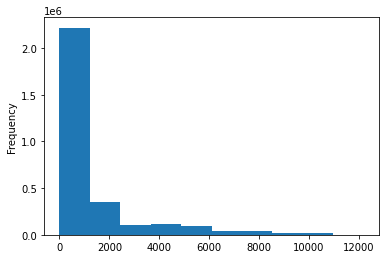

In [36]:
exp_dest_hotelprof.toPandas()\
                  .orig_destination_distance\
                  .plot.hist()

# Categorizing the Origin to Destination distance
Origin Destination distance is going to be categorized as follows :

1. "Near"          - orig_destination_distance = [0,1000] kms
2. "Medium"        - orig_destination_distance = (1000,6000] kms
3. "Far"           - orig_destination_distance >  6000 kms
4. "Not Applicable"- orig_destination_distance = -1 kms (For null cases)

In [37]:
# Categorization based on the distribution
totrows = exp_dest_hotelprof.count()
origin_dest_cat_df = exp_dest_hotelprof\
   .withColumn("Dist_Category", when((col("orig_destination_distance")>=0) & (col("orig_destination_distance")<=1000),"Near")\
                               .when((col("orig_destination_distance")>1000) & (col("orig_destination_distance")<=6000),"Medium")\
                               .when((col("orig_destination_distance")>6000) ,"Far")\
                               .otherwise("Not Applicable"))\
    .cache() # optimization to make the processing faster

#Counting the frequency in each category
origin_dest_cat_df.select("Dist_Category", "orig_destination_distance")\
                     .groupBy("Dist_Category")\
                     .agg(count("Dist_Category").alias("orig_dest_dist"), \
                          (count("Dist_Category")/totrows*100).alias("Ratio"))\
                     .orderBy("Dist_Category")\
                     .select("Dist_Category","orig_dest_dist",round("Ratio",2).alias("RoundedRatio")).show()

+--------------+--------------+------------+
| Dist_Category|orig_dest_dist|RoundedRatio|
+--------------+--------------+------------+
|           Far|        120499|        4.02|
|        Medium|        766354|       25.54|
|          Near|       1098661|       36.61|
|Not Applicable|       1015179|       33.83|
+--------------+--------------+------------+



# Business Question?

**1. Which continent sees the visitors travelling the most distance?**

**2. Which continent only receives nearby customers?**

For answering this questions we need to group the data based on ***hotel_continent***, followed by a grouping based on ***Distance Category*** and hotel continent. Once these two are joined based on ***hotel_continent***, we get the necessary grouped information to answer the above questions.

In [58]:
totalbookingscontinents = \
   exp_dest_hotelprof.where(col("orig_destination_distance")!=-1)\
            .groupBy("hotel_continent")\
            .agg(count(lit(1)).alias("TotalBookings")) # Counting the number of customers based on hotel_continent

orig_dest_continents = \
  origin_dest_cat_df.where(col("Dist_Category")!="Not Applicable") \
                       .select("hotel_continent", "Dist_Category")\
                       .groupBy("hotel_continent", "Dist_Category")\
                       .agg(count(lit(1)).alias("Count"))\
                       .orderBy(desc("Count")) # grouping by hotel continent and Distance Category

combinedcontinentsDF = \
  orig_dest_continents\
     .join(totalbookingscontinents, "hotel_continent") \
     .withColumn("BookingRatio", round(col("Count")/col("TotalBookings")*100,2))\
     .orderBy(col("BookingRatio").desc())\
     .cache() # joining keeping the hotel_continent column as reference\

display(Markdown("Pivot table based on countries and Distance Category (Booking Ratio in \%):"))
combinedcontinentsDF\
   .groupBy("hotel_continent")\
   .pivot("Dist_Category")\
   .max("BookingRatio")\
   .orderBy(col("Far").desc(), col("Medium").desc(), col("Near").desc())\
   .fillna(0, subset=["Far","Medium","Near"]).show()

display(Markdown("Top destinations continents based on Booking Ratio grouped by Distance Category (in \%):"))
combinedcontinentsDF.show()



Pivot table based on countries and Distance Category (Booking Ratio in \%):

+---------------+-----+------+-----+
|hotel_continent|  Far|Medium| Near|
+---------------+-----+------+-----+
|              3|67.27| 31.82| 0.92|
|              5| 60.2| 37.69| 2.11|
|              0|41.43| 22.28|36.29|
|              1| 20.0|  80.0|  0.0|
|              6| 9.74| 64.75|25.51|
|              4| 3.17| 78.32|18.51|
|              2| 0.77|  31.0|68.23|
+---------------+-----+------+-----+



Top destinations continents based on Booking Ratio grouped by Distance Category (in \%):

+---------------+-------------+------+-------------+------------+
|hotel_continent|Dist_Category| Count|TotalBookings|BookingRatio|
+---------------+-------------+------+-------------+------------+
|              1|       Medium|     4|            5|        80.0|
|              4|       Medium|106814|       136384|       78.32|
|              2|         Near|996068|      1459937|       68.23|
|              3|          Far| 62901|        93511|       67.27|
|              6|       Medium|167769|       259106|       64.75|
|              5|          Far|  5080|         8439|        60.2|
|              0|          Far| 11655|        28132|       41.43|
|              5|       Medium|  3181|         8439|       37.69|
|              0|         Near| 10209|        28132|       36.29|
|              3|       Medium| 29752|        93511|       31.82|
|              2|       Medium|452566|      1459937|        31.0|
|              6|         Near| 66097|       259106|       25.51|
|         

# Business Question?

**1. Which country sees the visitors travelling the most distance?**

**2. Which country only receives nearby customers?**

For answering this questions we need to group the data based on ***hotel_country***, followed by a grouping based on ***Distance Category*** and hotel country. Once these two are joined based on ***hotel_country***, we get the necessary grouped information to answer the above questions.

In [59]:
totalbookingscountry = \
   exp_dest_hotelprof.where(col("orig_destination_distance")!=-1)\
            .groupBy("hotel_country")\
            .agg(count(lit(1)).alias("TotalBookings"))
orig_dest_countries = \
  origin_dest_cat_df.where(col("Dist_Category")!="Not Applicable") \
                       .select("hotel_country", "Dist_Category")\
                       .groupBy("hotel_country", "Dist_Category")\
                       .agg(count(lit(1)).alias("Count")).orderBy(desc("Count"))

combined_country_df = \
  orig_dest_countries\
     .join(totalbookingscountry, "hotel_country")\
     .withColumn("BookingRatio", round(col("Count")/col("TotalBookings")*100,2))\
     .orderBy(col("TotalBookings").desc(),col("BookingRatio").desc())\
     .cache() # optimization to make the processing faster

display(Markdown("Pivot table based on countries and Distance Category (Booking Ratio in \%):"))
combined_country_df\
   .groupBy("hotel_country")\
   .pivot("Dist_Category")\
   .min("BookingRatio")\
   .orderBy(col("Far").desc(), col("Medium").desc(), col("Near").desc())\
   .fillna(0, subset=["Far","Medium","Near"]).show()

display(Markdown("Top destinations country based on Booking Ratio grouped by Distance Category (in \%):"))
combined_country_df.limit(10).show()

Pivot table based on countries and Distance Category (Booking Ratio in \%):

+-------------+-----+------+----+
|hotel_country|  Far|Medium|Near|
+-------------+-----+------+----+
|           39|100.0|   0.0| 0.0|
|          149|100.0|   0.0| 0.0|
|           91|100.0|   0.0| 0.0|
|          195|100.0|   0.0| 0.0|
|            6|100.0|   0.0| 0.0|
|          187|100.0|   0.0| 0.0|
|          114|96.55|  3.45| 0.0|
|          139|90.12|  9.88| 0.0|
|           82|89.39| 10.61| 0.0|
|          108| 89.2|  10.8| 0.0|
|          202| 88.2|  11.8| 0.0|
|            2|86.55| 13.45| 0.0|
|          130|86.14| 13.86| 0.0|
|           89|86.13| 13.87| 0.0|
|          122|83.81| 16.19| 0.0|
|          110|83.44| 16.56| 0.0|
|          155|83.33| 16.67| 0.0|
|          129|82.94| 17.06| 0.0|
|          181|81.82| 18.18| 0.0|
|          203| 81.7| 17.55|0.75|
+-------------+-----+------+----+
only showing top 20 rows



Top destinations country based on Booking Ratio grouped by Distance Category (in \%):

+-------------+-------------+------+-------------+------------+
|hotel_country|Dist_Category| Count|TotalBookings|BookingRatio|
+-------------+-------------+------+-------------+------------+
|           50|         Near|871227|      1294956|       67.28|
|           50|       Medium|413403|      1294956|       31.92|
|           50|          Far| 10326|      1294956|         0.8|
|          198|         Near|124841|       164981|       75.67|
|          198|       Medium| 39163|       164981|       23.74|
|          198|          Far|   977|       164981|        0.59|
|            8|       Medium| 42488|        61932|        68.6|
|            8|         Near| 19037|        61932|       30.74|
|            8|          Far|   407|        61932|        0.66|
|          105|       Medium| 26787|        52914|       50.62|
+-------------+-------------+------+-------------+------------+



# Business Question?

**1. Which category(distance) of customers prefer which hotel clusters?**

For answering this questions we need to group the data based on ***hotel_cluster***, followed by a grouping based on ***Distance Category*** and hotel cluster. Once these two are joined based on ***hotel_cluster***, we get the necessary grouped information to answer the above questions.

In [56]:
totalbookingscluster = \
   exp_dest_hotelprof.where(col("orig_destination_distance")!=-1)\
            .groupBy("hotel_cluster")\
            .agg(count(lit(1)).alias("TotalBookings"))
orig_dest_cluster = \
  origin_dest_cat_df.where(col("Dist_Category")!="Not Applicable") \
                       .select("hotel_cluster", "Dist_Category")\
                       .groupBy("hotel_cluster", "Dist_Category")\
                       .agg(count(lit(1)).alias("Count")).orderBy(desc("Count"))

combined_cluster_df = \
  orig_dest_cluster\
     .join(totalbookingscluster, "hotel_cluster")\
     .withColumn("BookingRatio", round(col("Count")/col("TotalBookings")*100,2))\
     .orderBy(col("TotalBookings").desc(),col("BookingRatio").desc())\
     .cache() # optimization to make the processing faster

display(Markdown("Pivot table based on hotel clusters and Distance Category (Booking Ratio in \%):"))
combined_cluster_df\
   .groupBy("hotel_cluster")\
   .pivot("Dist_Category")\
   .min("BookingRatio")\
   .orderBy(col("Far").desc(), col("Medium").desc(), col("Near").desc())\
   .fillna(0, subset=["Far","Medium","Near"]).limit(10).show()

display(Markdown("Top destinations hotel clusters based on Booking Ratio grouped by Distance Category (in \%):"))
combined_cluster_df.limit(10).show()

Pivot table based on hotel clusters and Distance Category (Booking Ratio in \%):

+-------------+-----+------+-----+
|hotel_cluster|  Far|Medium| Near|
+-------------+-----+------+-----+
|           12|38.81| 43.73|17.47|
|           46|37.44| 46.69|15.87|
|           81|34.41| 40.99| 24.6|
|           67|30.89| 52.87|16.25|
|           57|30.22| 39.12|30.66|
|           38|28.44| 47.72|23.84|
|           36|27.88| 50.97|21.15|
|           63|26.64|  44.6|28.76|
|           64|26.33| 57.26|16.41|
|           58| 26.3| 56.12|17.58|
+-------------+-----+------+-----+



Top destinations hotel clusters based on Booking Ratio grouped by Distance Category (in \%):

+-------------+-------------+-----+-------------+------------+
|hotel_cluster|Dist_Category|Count|TotalBookings|BookingRatio|
+-------------+-------------+-----+-------------+------------+
|           91|         Near|73104|        98550|       74.18|
|           91|       Medium|24908|        98550|       25.27|
|           91|          Far|  538|        98550|        0.55|
|           48|         Near|50032|        67668|       73.94|
|           48|       Medium|17093|        67668|       25.26|
|           48|          Far|  543|        67668|         0.8|
|           42|         Near|42173|        57570|       73.26|
|           42|       Medium|14854|        57570|        25.8|
|           42|          Far|  543|        57570|        0.94|
|           28|         Near|32318|        48370|       66.81|
+-------------+-------------+-----+-------------+------------+



# Business Question?

**1. Which hotel clusters are preferred most by the customers?**


In [47]:
totalbookingscluster = \
   exp_dest_hotelprof.where(col("orig_destination_distance")!=-1)\
            .groupBy("hotel_cluster")\
            .agg(count(lit(1)).alias("TotalBookings"))\
            .orderBy(col("TotalBookings").desc()).show()

+-------------+-------------+
|hotel_cluster|TotalBookings|
+-------------+-------------+
|           91|        98550|
|           48|        67668|
|           42|        57570|
|           28|        48370|
|           18|        43423|
|           50|        42327|
|           95|        41929|
|           16|        41704|
|           59|        40991|
|           41|        36397|
|           21|        35290|
|           47|        34521|
|           72|        33934|
|           98|        33697|
|           32|        33422|
|           13|        33413|
|            6|        30707|
|            1|        30438|
|           68|        30078|
|           39|        29826|
+-------------+-------------+
only showing top 20 rows



# Family Profiling

In the following analysis, we will query about the family structure and their preferences for the following attributes:

1. srch_destination_type_id
2. hotel_continent
3. hotel_country
4. hotel_market
5. hotel_cluster
6. user_id
7. is_mobile
8. channel
9. srch_adults_cnt
10. srch_children_cnt
11. is_booking
12. orig_destination_distance

This analysis provides with a overall idea in the family category.

In [41]:
family_profiling = spark.read.parquet("../Spark_Assignment/Expedia/parquet/")
family_profiling = family_profiling.select(col('orig_destination_distance').cast("int"),
                                           col('user_id').cast("int"),
                                           col('is_mobile').cast("int"),
                                           col('channel').cast("int"),
                                           col('srch_adults_cnt').cast("int"),
                                           col('srch_children_cnt').cast("int"),
                                           col('srch_destination_type_id').cast("int"),
                                           col('is_booking').cast("int"),
                                           col('hotel_continent').cast("int"),
                                           col('hotel_country').cast("int"),
                                           col('hotel_market').cast("int"),
                                           col('hotel_cluster').cast("int"))

**Replace NA from orig_dest_distanc to -1**

In [42]:
family_profiling = family_profiling.fillna(-1, subset=["orig_destination_distance"])

# Categorizing the Origin to Destination distance
Origin Destination distance is going to be categorized as follows :

1. "Near"          - orig_destination_distance = [0,1000] kms
2. "Medium"        - orig_destination_distance = (1000,6000] kms
3. "Far"           - orig_destination_distance >  6000 kms
4. "Not Applicable"- orig_destination_distance = -1 kms (For null cases)

In [43]:
totrows = family_profiling.count()
family_profiling = family_profiling\
   .withColumn("Dist_Category", when((col("orig_destination_distance")>=0) & (col("orig_destination_distance")<=1000),"Near")\
                               .when((col("orig_destination_distance")>1000) & (col("orig_destination_distance")<=6000),"Medium")\
                               .when((col("orig_destination_distance")>6000) ,"Far")\
                               .otherwise("Not Applicable"))\
    .cache() # optimization to make the processing faster

# Business Question?
**1. How many channels are being used?**

**2. Which Channel is most used and in what device?**

To answer this question, we need the count based on ***channel*** first, followed by grouping by ***channel*** and ***is_mobile***, making a count for each category. Finally we go forward with a join keeping the ***channel*** as reference and arranging according to business questions.

In [54]:
# Number of distinct channels
totalcount=family_profiling.where(col("orig_destination_distance")!=-1)\
            .groupBy("channel")\
            .agg(count(lit(1)).alias("FreqCount"))\
            .orderBy(col("FreqCount").desc()).cache()

channel_profile = \
  family_profiling.where((col("Dist_Category")!="Not Applicable") & (col("is_booking")==1))\
                       .select("channel", "is_mobile")\
                       .groupBy("channel", "is_mobile")\
                       .agg(count(lit(1)).alias("Count")).orderBy(desc("Count")).cache() # Grouping by Channel and is_mobile


combined_channel_df = \
  channel_profile\
     .join(totalcount, "channel")\
     .withColumn("BookingRatio", round(col("Count")/col("FreqCount")*100,2))\
     .orderBy(col("BookingRatio").desc())\
     .cache() # joining based on channel as reference column

display(Markdown("Pivot table based on Channel and Device Category (Booking Ratio in \%):"))
combined_channel_df\
   .groupBy("channel")\
   .pivot("is_mobile")\
   .min("BookingRatio")\
   .orderBy(col("0").desc(), col("1").desc())\
   .show()

Pivot table based on Channel and Device Category (Booking Ratio in \%):

+-------+-----+----+
|channel|    0|   1|
+-------+-----+----+
|      4|12.94|0.97|
|      5| 9.03|0.25|
|      9|  7.9|0.87|
|      8| 7.68|0.76|
|      0| 6.59|0.97|
|     10| 6.39|0.54|
|      1|  6.3|0.88|
|      2| 5.53|0.81|
|      3| 5.42|0.44|
|      7| 4.22|0.26|
|      6| 4.01|0.38|
+-------+-----+----+



**Counting the total number of friends and family to be included in the search**

In [45]:
family_profiling = family_profiling\
                    .withColumn("total_members", col("srch_adults_cnt")+col("srch_children_cnt")).cache()

# Categorizing the total number of family members
***total_members*** is going to be categorized as follows :

1. "Alone"         - total_members = 1 member
2. "Couple"        - total_members = 2 members
3. "Fam&Frnds"     - total_members > 2 members
4. "Not Applicable"- missing or negative values

In [49]:
family_profiling = family_profiling\
   .withColumn("Fam_Category", when((col("total_members")==1),"Alone")\
                               .when((col("total_members")==2),"Couple")\
                               .when((col("total_members")>2) ,"Fam&Frnds")\
                               .otherwise("Not Applicable"))\

totalfamcount=family_profiling.where((col("orig_destination_distance")!=-1) & (col("is_booking")==1))\
            .groupBy("Fam_Category")\
            .agg(count(lit(1)).alias("FreqCount"))\
            .orderBy(col("FreqCount").desc()).cache() # Categorizing the dataset counting for each group

totalfamcount.show()

+--------------+---------+
|  Fam_Category|FreqCount|
+--------------+---------+
|        Couple|   953440|
|         Alone|   554823|
|     Fam&Frnds|   474040|
|Not Applicable|     3211|
+--------------+---------+



# Business Question

**Which Family Category preferred which distance category type vacation?**

To answer this question, we need the count based on ***Fam_Category*** first(alraedy calculated), followed by grouping by ***Fam_Category*** and ***Dist_Category***, making a count for each category. Finally we go forward with a join keeping the ***Fam_Category*** as reference and arranging according to business questions.

In [53]:
Fam_Dist_category = \
  family_profiling.where((col("Dist_Category")!="Not Applicable") \
                         & (col("is_booking")==1) & (col("Fam_Category")!="Not Applicable"))\
                       .select("Dist_Category", "Fam_Category")\
                       .groupBy("Dist_Category", "Fam_Category")\
                       .agg(count(lit(1)).alias("Count"))\
                       .orderBy(desc("Count")).cache() # grouping based on Fam_Category and Dist_Category


combined_Fam_Dist_category = \
  Fam_Dist_category\
     .join(totalfamcount, "Fam_Category")\
     .withColumn("BookingRatio", round(col("Count")/col("FreqCount")*100,2))\
     .orderBy(col("BookingRatio").desc())\
     .cache() # joining keeping Fam_Category as reference

display(Markdown("Pivot table based on family and destination distance Category (Booking Ratio in \%):"))
combined_Fam_Dist_category\
   .groupBy("Fam_Category")\
   .pivot("Dist_Category")\
   .min("BookingRatio")\
   .show()

combined_Fam_Dist_category.show()

Pivot table based on family and destination distance Category (Booking Ratio in \%):

+------------+----+------+-----+
|Fam_Category| Far|Medium| Near|
+------------+----+------+-----+
|   Fam&Frnds|5.67| 37.73| 56.6|
|       Alone|6.06| 39.09|54.85|
|      Couple|6.28| 38.66|55.05|
+------------+----+------+-----+

+------------+-------------+------+---------+------------+
|Fam_Category|Dist_Category| Count|FreqCount|BookingRatio|
+------------+-------------+------+---------+------------+
|   Fam&Frnds|         Near|268329|   474040|        56.6|
|      Couple|         Near|524901|   953440|       55.05|
|       Alone|         Near|304322|   554823|       54.85|
|       Alone|       Medium|216862|   554823|       39.09|
|      Couple|       Medium|368628|   953440|       38.66|
|   Fam&Frnds|       Medium|178855|   474040|       37.73|
|      Couple|          Far| 59911|   953440|        6.28|
|       Alone|          Far| 33639|   554823|        6.06|
|   Fam&Frnds|          Far| 26856|   474040|        5.67|
+------------+-------------+------+---------+------------+



# Business Question

**Which Family Category preferred which Destination type during vacation?**

To answer this question, we need the count based on ***Fam_Category*** first(alraedy calculated), followed by grouping by ***Fam_Category*** and ***srch_destination_type_id***, making a count for each category. Finally we go forward with a join keeping the ***Fam_Category*** as reference and arranging according to business questions.

In [52]:
Fam_Dest_category = \
  family_profiling.where((col("Dist_Category")!="Not Applicable") 
                         & (col("is_booking")==1) & (col("Fam_Category")!="Not Applicable"))\
                       .select("srch_destination_type_id", "Fam_Category")\
                       .groupBy("srch_destination_type_id", "Fam_Category")\
                       .agg(count(lit(1)).alias("Count")).orderBy(desc("Count")).cache()


combined_Fam_Dest_category = \
  Fam_Dest_category\
     .join(totalfamcount, "Fam_Category")\
     .withColumn("BookingRatio", round(col("Count")/col("FreqCount")*100,2))\
     .orderBy(col("BookingRatio").desc())\
     .cache()

display(Markdown("Pivot table based on family and search destination type Category (Booking Ratio in \%):"))
combined_Fam_Dest_category\
   .groupBy("Fam_Category")\
   .pivot("srch_destination_type_id")\
   .min("BookingRatio")\
   .show()

combined_Fam_Dest_category.show()

Pivot table based on family and search destination type Category (Booking Ratio in \%):

+------------+-----+----+----+-----+-----+----+----+---+
|Fam_Category|    1|   3|   4|    5|    6|   7|   8|  9|
+------------+-----+----+----+-----+-----+----+----+---+
|   Fam&Frnds|55.12|8.39|5.22| 5.87|25.13|0.01|0.26|0.0|
|       Alone|50.93|9.32|2.71|10.34|26.13|0.01|0.54|0.0|
|      Couple|54.05|8.84|3.91| 6.44|26.46|0.01| 0.3|0.0|
+------------+-----+----+----+-----+-----+----+----+---+

+------------+------------------------+------+---------+------------+
|Fam_Category|srch_destination_type_id| Count|FreqCount|BookingRatio|
+------------+------------------------+------+---------+------------+
|   Fam&Frnds|                       1|261301|   474040|       55.12|
|      Couple|                       1|515288|   953440|       54.05|
|       Alone|                       1|282598|   554823|       50.93|
|      Couple|                       6|252254|   953440|       26.46|
|       Alone|                       6|144996|   554823|       26.13|
|   Fam&Frnds|                       6|1

# Graph Analysis

We need to create the dataframes for vetices and edges. 

***Vertices*** are taken as the origin and destination country.
In ***Edges***, user location country is taken as ***source*** and destination country as ***destination***

In [29]:

exp_copy=exp # making a copy so as not to disturb the original dataset

vertices1 = exp_copy.select(col("user_location_country").alias("id")).distinct() # Extracting origin countries
vertices2 = exp_copy.select(col("hotel_country").alias("id")).distinct() # extracting destination countries
vertices = vertices1.union(vertices2) # making a Union and taking distinct values

edges = exp_copy.withColumnRenamed("user_location_country", "src")\
                               .withColumnRenamed("hotel_country", "dst")\
                               .select("src", "dst") # preparing the edges dataframe

**Preapring the Graphframe** 

In [30]:
graph = GraphFrame(vertices, edges)

graph.cache() # keeping it in cache for better optimization, due to iterative calculations

GraphFrame(v:[id: int], e:[src: int, dst: int])

# Business Question?

**Which is the most common holidaying destination from the same country visitors?**

To solve this we need to count the edges from each of the vertices to their destination vertices.

In [31]:
graph.edges\
            .groupBy("src", "dst")\
            .count()\
            .orderBy(desc("count"))\
            .show(5,False)

graph.edges\
            .groupBy("src", "dst")\
            .count()\
            .orderBy(asc("count"))\
            .show(5,False)

+---+---+--------+
|src|dst|count   |
+---+---+--------+
|66 |50 |13566967|
|205|50 |1721373 |
|66 |8  |1440748 |
|205|198|1160095 |
|66 |198|454392  |
+---+---+--------+
only showing top 5 rows

+---+---+-----+
|src|dst|count|
+---+---+-----+
|229|31 |1    |
|48 |160|1    |
|202|12 |1    |
|43 |151|1    |
|92 |21 |1    |
+---+---+-----+
only showing top 5 rows



# Business Question?

**Which is the most searched common holidaying destination ?**

We need the vertex with the maximum indegree.

In [32]:
inDeg = graph.inDegrees
inDeg.orderBy(desc("inDegree")).show(5, False)

+---+--------+
|id |inDegree|
+---+--------+
|50 |18015006|
|8  |1914010 |
|198|1762641 |
|105|1350403 |
|70 |1199342 |
+---+--------+
only showing top 5 rows



# Business Question?

**Which country sees the maximum searches of vacation outside their own country?**

We need the vertex with the maximum outdegree

In [33]:
outDeg = graph.outDegrees
outDeg.orderBy(desc("outDegree")).show(5, False)

+---+---------+
|id |outDegree|
+---+---------+
|66 |20346844 |
|205|4188283  |
|3  |2212572  |
|69 |1931466  |
|77 |948722   |
+---+---------+
only showing top 5 rows



# Business Question?

**Which country's visitors search for vacation within their origin country?**

We need a structural query to get answer of this question. ***Motif finding*** refers to searching for structural patterns in a graph. Query will be "(a)-[]->(a)" expresses an edge e from vertex a to vertex a. 

The edge e is ***empty*** as we are not considering any weight of the edges.

In [34]:
res = graph.find("(a)-[]->(a)").groupBy("a").count().orderBy(desc("count"))\
          
res.show(5)

+----+-----+
|   a|count|
+----+-----+
|[68]|27280|
|[77]|22086|
|[50]|13334|
|[46]|12230|
|[70]| 5528|
+----+-----+
only showing top 5 rows

